# JOINs e UNIONs

---


Combine informações de várias tabelas.

introdução

No microcurso Intro to SQL, você aprendeu como usar INNER JOIN para consolidar informações de duas tabelas diferentes. Agora você aprenderá mais alguns tipos de JOIN, além de como usar UNIONs para extrair informações de várias tabelas.

Ao longo do caminho, trabalharemos com duas mesas imaginárias, chamadas de donos e animais de estimação.

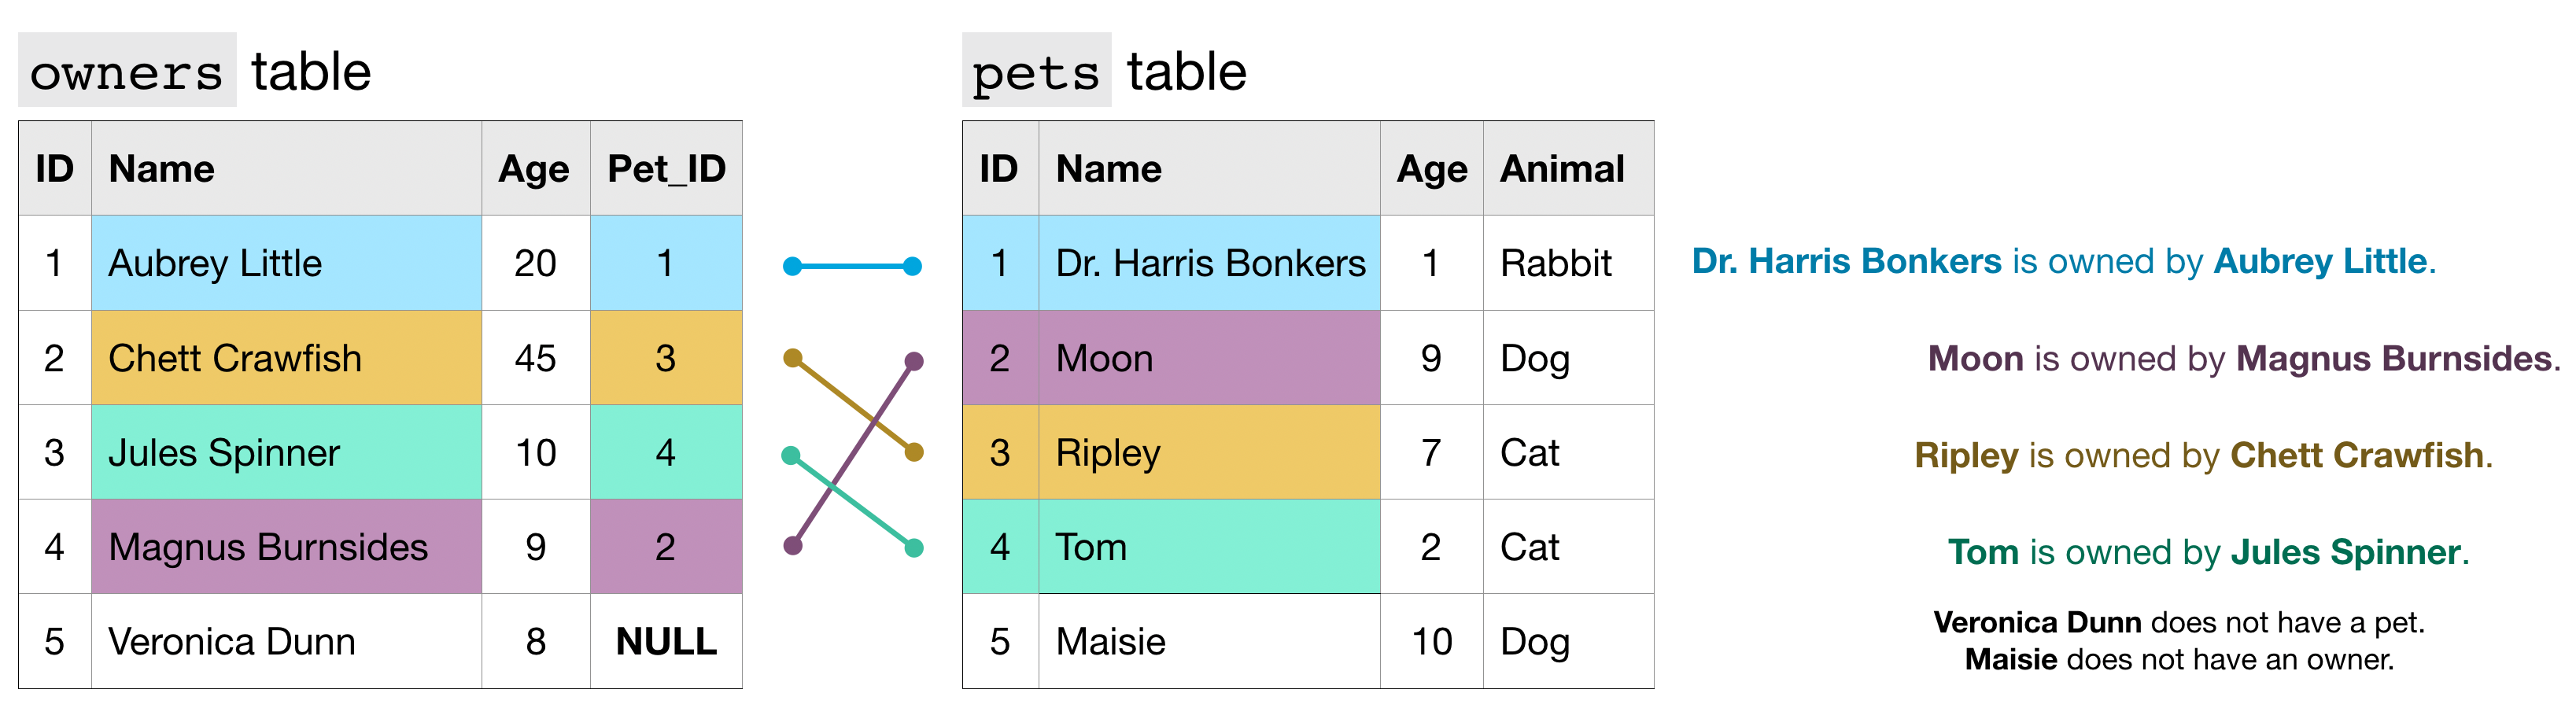

Cada linha da tabela de proprietários identifica um proprietário de animal de estimação diferente, em que a coluna ID é um identificador exclusivo. A coluna Pet_ID (na tabela de proprietários) contém o ID do animal de estimação que pertence ao proprietário (esse número corresponde ao ID do animal de estimação da tabela de animais de estimação).

Por exemplo,

* a tabela de animais de estimação mostra que o Dr. Harris Bonkers é o animal de estimação com ID 1.
* A tabela de proprietários mostra que Aubrey Little é o dono do animal de estimação com ID 1.

Juntando esses dois fatos, o Dr. Harris Bonkers é propriedade de Aubrey Little. Da mesma forma, como Veronica Dunn não possui um Pet_ID correspondente, ela não possui um animal de estimação. E, como 5 não aparece na coluna Pet_ID, Maisie não tem dono.

## JOINs

---


Lembre-se de que podemos usar um INNER JOIN para extrair linhas de ambas as tabelas em que o valor na coluna Pet_ID na tabela proprietários tenha uma correspondência na coluna ID da tabela pets.

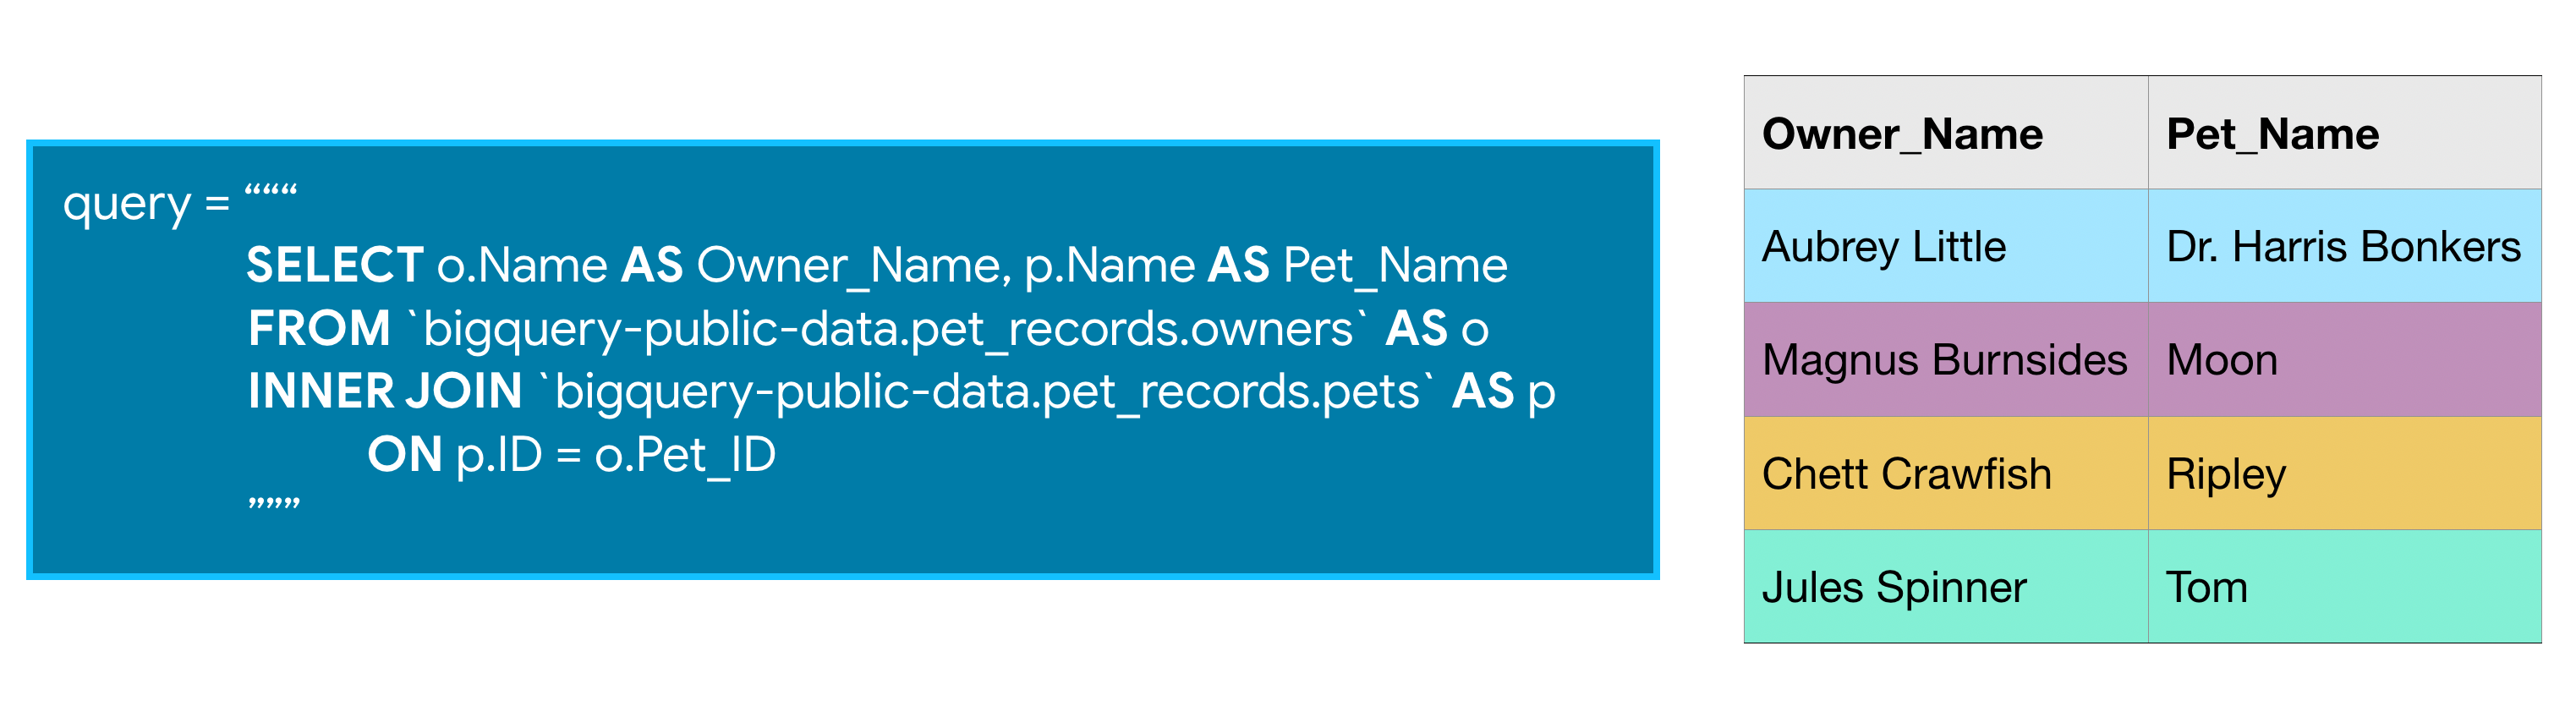

Neste caso, Veronica Dunn e Maisie não estão incluídas nos resultados. Mas e se, em vez disso, quisermos criar uma tabela contendo todos os animais de estimação, independentemente de eles terem donos? Ou, e se quisermos combinar todas as linhas em ambas as tabelas? Nesses casos, precisamos apenas usar um tipo diferente de JOIN.

Por exemplo, para criar uma tabela contendo todas as linhas da tabela de proprietários, usamos um LEFT JOIN. Nesse caso, "esquerda" se refere à tabela que aparece antes do JOIN na consulta. ("Right" refere-se à tabela que está após o JOIN.)

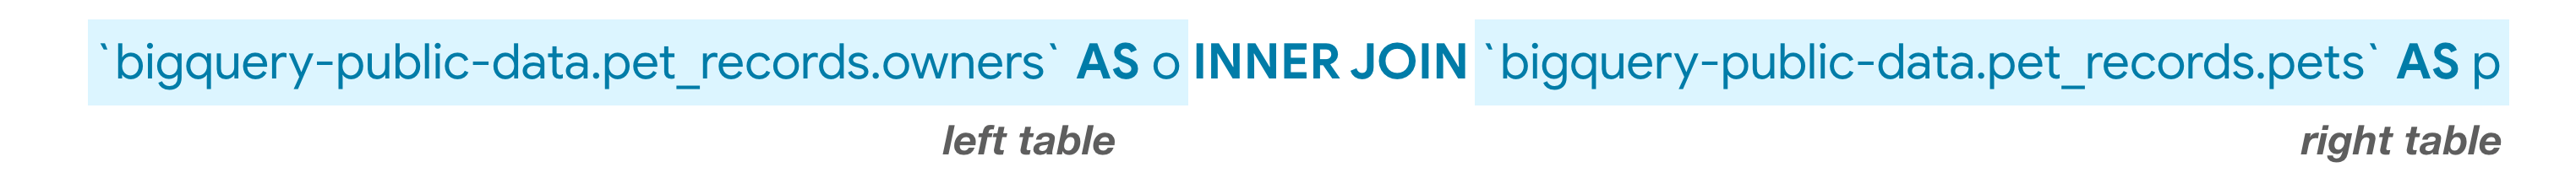

Substituir INNER JOIN na consulta acima por LEFT JOIN retorna todas as linhas em que as duas tabelas têm entradas correspondentes, juntamente com todas as linhas na tabela à esquerda (se houver uma correspondência ou não).

Se, em vez disso, usarmos um RIGHT JOIN, obteremos as linhas correspondentes, juntamente com todas as linhas da tabela correta (se houver uma correspondência ou não).

Finalmente, um FULL JOIN retorna todas as linhas de ambas as tabelas. Observe que, em geral, qualquer linha que não tenha uma correspondência em ambas as tabelas terá entradas NULL para os valores ausentes. Você pode ver isso na imagem abaixo.

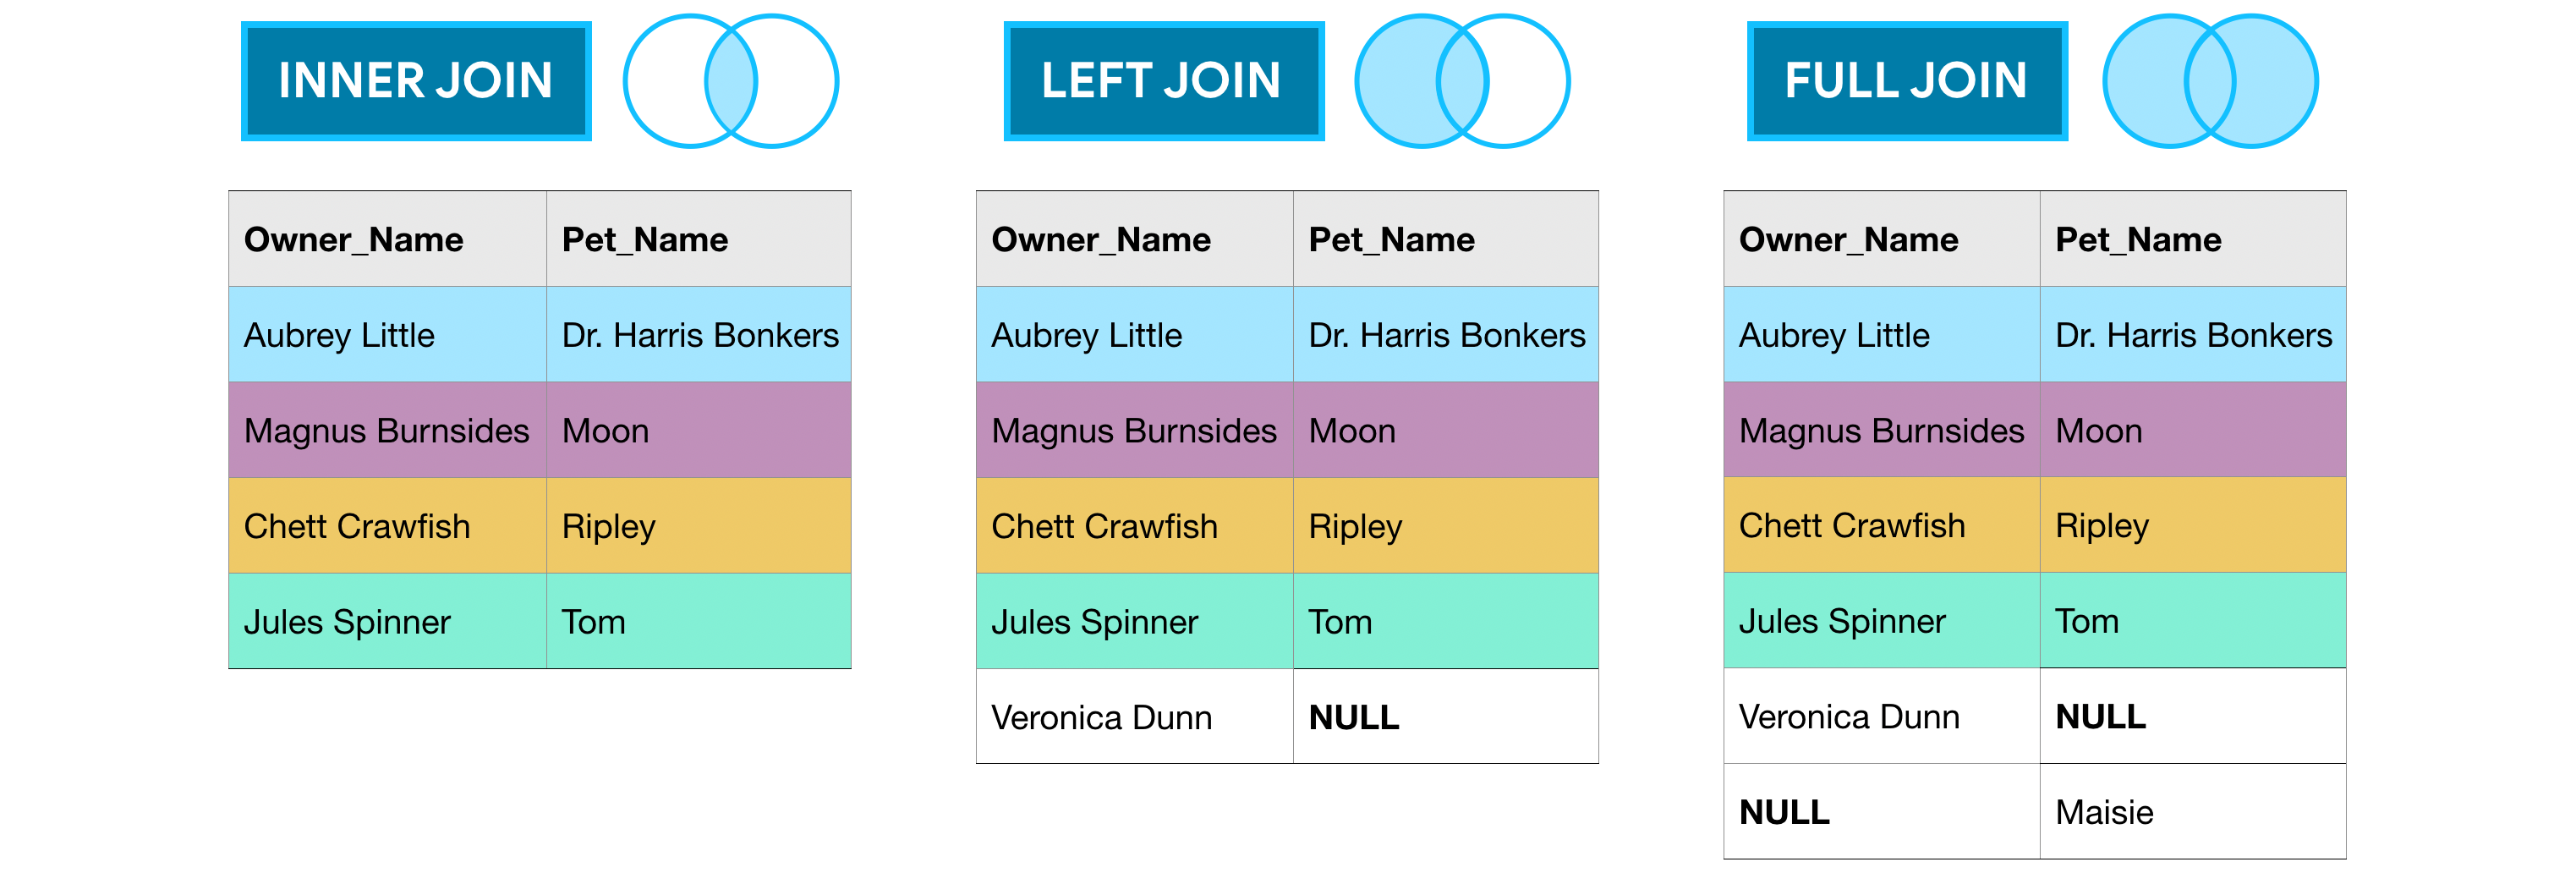

UNIONs

---


Como você viu, os JOINs combinam horizontalmente os resultados de diferentes tabelas. Se, em vez disso, você quiser concatenar colunas verticalmente, poderá fazê-lo com um UNION. A consulta de exemplo abaixo combina as colunas Idade de ambas as tabelas.

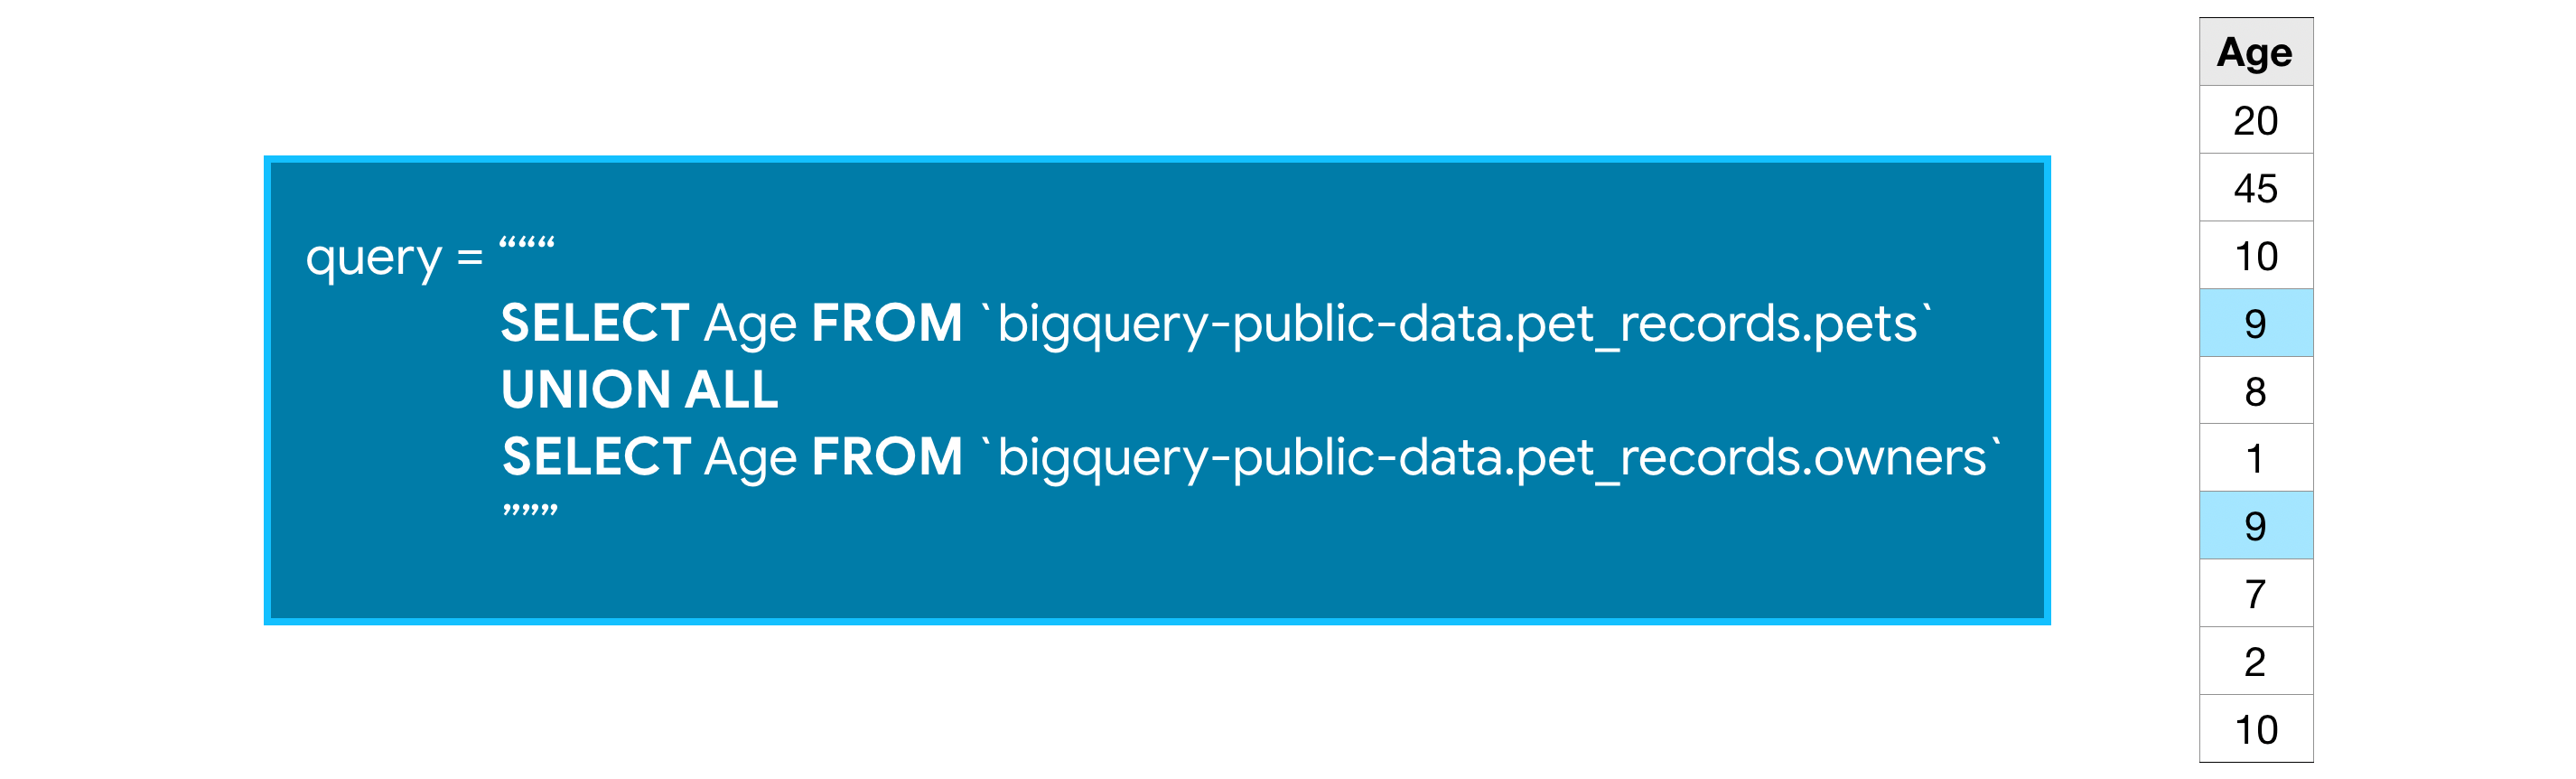

Observe que com um UNION, os tipos de dados de ambas as colunas devem ser os mesmos, mas os nomes das colunas podem ser diferentes. (Então, por exemplo, não podemos pegar a coluna UNION of the Age da tabela de proprietários e a coluna Pet_Name da tabela de animais de estimação.)

Usamos UNION ALL para incluir valores duplicados - você notará que 9 aparece na tabela de proprietários e na tabela de animais de estimação e aparece duas vezes nos resultados concatenados. Se você quiser descartar valores duplicados, basta alterar UNION ALL na consulta para UNION DISTINCT.

## Exemplo

---



Trabalharemos com o conjunto de dados do Hacker News. Começamos revisando as primeiras linhas da tabela de comentários. (O código correspondente está oculto, mas você pode reexibi-lo clicando no botão "Código" abaixo.)

In [ ]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

Você também trabalhará com a tabela de histórias.

In [ ]:
# Construct a reference to the "stories" table
table_ref = dataset_ref.table("stories")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

Como você já está familiarizado com JOINs do microcurso Intro to SQL, trabalharemos com um exemplo relativamente complexo de um JOIN que usa uma expressão de tabela comum (CTE).

A consulta abaixo extrai informações das tabelas de histórias e comentários para criar uma tabela que mostra todas as histórias publicadas em 1º de janeiro de 2012, juntamente com o número correspondente de comentários. Usamos um LEFT JOIN para que os resultados incluam histórias que não receberam comentários.

In [ ]:
# Query to select all stories posted on January 1, 2012, with number of comments
join_query = """
             WITH c AS
             (
             SELECT parent, COUNT(*) as num_comments
             FROM `bigquery-public-data.hacker_news.comments` 
             GROUP BY parent
             )
             SELECT s.id as story_id, s.by, s.title, c.num_comments
             FROM `bigquery-public-data.hacker_news.stories` AS s
             LEFT JOIN c
             ON s.id = c.parent
             WHERE EXTRACT(DATE FROM s.time_ts) = '2012-01-01'
             ORDER BY c.num_comments DESC
             """

# Run the query, and return a pandas DataFrame
join_result = client.query(join_query).result().to_dataframe()
join_result.head()

Como os resultados são ordenados pela coluna num_comments, as histórias sem comentários aparecem no final do DataFrame. (Lembre-se que NaN significa "não é um número".)

In [ ]:
# None of these stories received any comments
join_result.tail()

Em seguida, escrevemos uma consulta para selecionar todos os nomes de usuário correspondentes aos usuários que escreveram histórias ou comentários em 1º de janeiro de 2014. Usamos UNION DISTINCT (em vez de UNION ALL) para garantir que cada usuário apareça na tabela no máximo uma vez.

In [ ]:
# Query to select all users who posted stories or comments on January 1, 2014
union_query = """
              SELECT c.by
              FROM `bigquery-public-data.hacker_news.comments` AS c
              WHERE EXTRACT(DATE FROM c.time_ts) = '2014-01-01'
              UNION DISTINCT
              SELECT s.by
              FROM `bigquery-public-data.hacker_news.stories` AS s
              WHERE EXTRACT(DATE FROM s.time_ts) = '2014-01-01'
              """

# Run the query, and return a pandas DataFrame
union_result = client.query(union_query).result().to_dataframe()
union_result.head()

Para obter o número de usuários que postaram em 1º de janeiro de 2014, precisamos apenas calcular o comprimento do DataFrame.

In [ ]:
# Number of users who posted stories or comments on January 1, 2014
len(union_result)